In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cityscapes/val/label/val181.png
/kaggle/input/cityscapes/val/label/val364.png
/kaggle/input/cityscapes/val/label/val414.png
/kaggle/input/cityscapes/val/label/val265.png
/kaggle/input/cityscapes/val/label/val203.png
/kaggle/input/cityscapes/val/label/val209.png
/kaggle/input/cityscapes/val/label/val279.png
/kaggle/input/cityscapes/val/label/val285.png
/kaggle/input/cityscapes/val/label/val126.png
/kaggle/input/cityscapes/val/label/val283.png
/kaggle/input/cityscapes/val/label/val239.png
/kaggle/input/cityscapes/val/label/val259.png
/kaggle/input/cityscapes/val/label/val210.png
/kaggle/input/cityscapes/val/label/val321.png
/kaggle/input/cityscapes/val/label/val278.png
/kaggle/input/cityscapes/val/label/val496.png
/kaggle/input/cityscapes/val/label/val207.png
/kaggle/input/cityscapes/val/label/val491.png
/kaggle/input/cityscapes/val/label/val121.png
/kaggle/input/cityscapes/val/label/val106.png
/kaggle/input/cityscapes/val/label/val125.png
/kaggle/input/cityscapes/val/label

In [2]:
"""
Install necessary packages. Since this is the Pix2Pix version of Cityscapes,
we don't need the full cityscapesscripts package, but it's helpful for 
understanding label mappings.
"""

!pip install cityscapesscripts opencv-python -q
print("✓ Packages installed successfully!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 473.6/473.6 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.6 which is incompatible.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.15.3 which is incompatible.
mkl-umath 0.1.1 requires nump

In [3]:
"""
Import all necessary libraries for processing the Pix2Pix Cityscapes dataset.
"""

import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2
import pandas as pd

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


In [4]:
"""
INSTRUCTIONS FOR KAGGLE:
1. Click "Add Data" in the right sidebar
2. Search for "shuvoalok cityscapes"
3. Add the dataset: https://www.kaggle.com/datasets/shuvoalok/cityscapes

This Pix2Pix version has a simpler structure:
/kaggle/input/cityscapes/
├── train/
│   ├── img/      (2975 RGB images)
│   └── label/    (2975 colored label images)
└── val/
    ├── img/      (500 RGB images)
    └── label/    (500 colored label images)

The labels are already in RGB color format, making processing easier!
"""

# Set the dataset path
CITYSCAPES_ROOT = '/kaggle/input/cityscapes'

# Verify the dataset exists
if os.path.exists(CITYSCAPES_ROOT):
    print(f"✓ Cityscapes dataset found at: {CITYSCAPES_ROOT}")
    
    # Check structure
    train_imgs = glob.glob(os.path.join(CITYSCAPES_ROOT, 'train/img/*.png'))
    train_labels = glob.glob(os.path.join(CITYSCAPES_ROOT, 'train/label/*.png'))
    val_imgs = glob.glob(os.path.join(CITYSCAPES_ROOT, 'val/img/*.png'))
    val_labels = glob.glob(os.path.join(CITYSCAPES_ROOT, 'val/label/*.png'))
    
    print(f"\nDataset contents:")
    print(f"  Training images: {len(train_imgs)}")
    print(f"  Training labels: {len(train_labels)}")
    print(f"  Validation images: {len(val_imgs)}")
    print(f"  Validation labels: {len(val_labels)}")
else:
    print(f"⚠ Warning: Dataset not found at {CITYSCAPES_ROOT}")
    print("Please add the dataset from: https://www.kaggle.com/datasets/shuvoalok/cityscapes")

✓ Cityscapes dataset found at: /kaggle/input/cityscapes

Dataset contents:
  Training images: 2975
  Training labels: 2975
  Validation images: 500
  Validation labels: 500


In [5]:
# ============================================================================
# CELL 4: Understand Pix2Pix Cityscapes Label Format
# ============================================================================
"""
The Pix2Pix Cityscapes labels are RGB colored images where each color
represents a specific class. We need to identify the RGB colors for:
- Road (our "direct" drivable area)
- Sidewalk (our "alternative" drivable area)
- Everything else (background)

Let's load a sample label and explore its unique colors.
"""

# Load a sample label image
sample_label_path = val_labels[0]
sample_label = np.array(Image.open(sample_label_path))

print(f"Sample label: {os.path.basename(sample_label_path)}")
print(f"Shape: {sample_label.shape}")
print(f"Data type: {sample_label.dtype}")

# Find unique colors in the label
pixels = sample_label.reshape(-1, 3)
unique_colors = np.unique(pixels, axis=0)

print(f"\nFound {len(unique_colors)} unique colors in this label")
print("\nFirst 10 unique RGB colors:")
print(unique_colors[:10])

# Cityscapes standard colors (from official documentation)
CITYSCAPES_COLORS = {
    'road': [128, 64, 128],           # Purple
    'sidewalk': [244, 35, 232],       # Pink/Magenta
    'building': [70, 70, 70],         # Dark gray
    'wall': [102, 102, 156],          # Gray-blue
    'fence': [190, 153, 153],         # Light gray
    'pole': [153, 153, 153],          # Gray
    'traffic_light': [250, 170, 30],  # Orange
    'traffic_sign': [220, 220, 0],    # Yellow
    'vegetation': [107, 142, 35],     # Green
    'terrain': [152, 251, 152],       # Light green
    'sky': [70, 130, 180],            # Blue
    'person': [220, 20, 60],          # Red
    'rider': [255, 0, 0],             # Bright red
    'car': [0, 0, 142],               # Dark blue
    'truck': [0, 0, 70],              # Very dark blue
    'bus': [0, 60, 100],              # Blue
    'train': [0, 80, 100],            # Cyan-blue
    'motorcycle': [0, 0, 230],        # Blue
    'bicycle': [119, 11, 32],         # Maroon
}

print("\n✓ Cityscapes color mapping defined!")
print(f"  Road color (RGB): {CITYSCAPES_COLORS['road']}")
print(f"  Sidewalk color (RGB): {CITYSCAPES_COLORS['sidewalk']}")

Sample label: val181.png
Shape: (96, 256, 3)
Data type: uint8

Found 9934 unique colors in this label

First 10 unique RGB colors:
[[0 0 2]
 [0 1 0]
 [0 1 1]
 [0 1 2]
 [0 1 3]
 [0 1 5]
 [0 2 0]
 [0 2 1]
 [0 2 4]
 [0 2 5]]

✓ Cityscapes color mapping defined!
  Road color (RGB): [128, 64, 128]
  Sidewalk color (RGB): [244, 35, 232]


In [6]:
# ============================================================================
# CELL 5: Define BDD100K Mapping Strategy
# ============================================================================
"""
BDD100K Drivable Area Label Format:
- Class 0: DIRECT - Directly drivable area (ego lane)
- Class 1: ALTERNATIVE - Alternatively drivable (adjacent lanes)
- Class 2: BACKGROUND - Non-drivable area

Mapping Strategy:
Cityscapes RGB Color → BDD100K Class
  [128, 64, 128] (road)      → 0 (direct)
  [244, 35, 232] (sidewalk)  → 1 (alternative)
  All other colors           → 2 (background)
"""

# Define the color to class mapping
RGB_TO_BDD100K = {
    (128, 64, 128): 0,    # road → direct drivable
    (244, 35, 232): 1,    # sidewalk → alternative drivable
    # All other colors will default to background (2)
}

print("=" * 70)
print("COLOR-BASED LABEL MAPPING")
print("=" * 70)
print(f"{'Cityscapes Color (RGB)':<30} → {'BDD100K Class':<20} {'Meaning'}")
print("-" * 70)
print(f"{'[128, 64, 128] (road)':<30} → {'0 (direct)':<20} Directly drivable")
print(f"{'[244, 35, 232] (sidewalk)':<30} → {'1 (alternative)':<20} Alternatively drivable")
print(f"{'All other colors':<30} → {'2 (background)':<20} Non-drivable")

print("\n✓ Color mapping strategy defined!")

COLOR-BASED LABEL MAPPING
Cityscapes Color (RGB)         → BDD100K Class        Meaning
----------------------------------------------------------------------
[128, 64, 128] (road)          → 0 (direct)           Directly drivable
[244, 35, 232] (sidewalk)      → 1 (alternative)      Alternatively drivable
All other colors               → 2 (background)       Non-drivable

✓ Color mapping strategy defined!


In [7]:
# ============================================================================
# CELL 6 UPDATED: Define Robust Color-Based Remapping Function
# ============================================================================
"""
UPDATED to handle JPEG compression artifacts and color variations.

Instead of exact color matching, we use nearest-color matching with tolerance.
This handles the ~10k color variations caused by image compression.
"""

def find_nearest_class(pixel_rgb, color_map, tolerance=30):
    """
    Find the nearest class for a pixel using Euclidean distance in RGB space.
    
    Args:
        pixel_rgb: RGB values of pixel (3,) or (H, W, 3)
        color_map: Dictionary of {(R, G, B): class_id}
        tolerance: Maximum distance to consider a match
    
    Returns:
        class_id or 2 (background) if no match within tolerance
    """
    min_distance = float('inf')
    best_class = 2  # Default to background
    
    for color, class_id in color_map.items():
        color_array = np.array(color)
        # Euclidean distance in RGB space
        distance = np.sqrt(np.sum((pixel_rgb - color_array) ** 2, axis=-1))
        
        if np.mean(distance) < min_distance:
            min_distance = np.mean(distance)
            best_class = class_id
    
    return best_class


def remap_rgb_label_to_bdd100k_robust(rgb_label, tolerance=30):
    """
    Convert RGB colored Cityscapes label to BDD100K format with tolerance
    for compression artifacts.
    
    Args:
        rgb_label (numpy.ndarray): RGB label image (H, W, 3)
        tolerance: Color distance tolerance (default 30 for JPEG artifacts)
    
    Returns:
        numpy.ndarray: BDD100K format label (H, W) with values 0, 1, 2
    """
    h, w = rgb_label.shape[:2]
    bdd_label = np.full((h, w), 2, dtype=np.uint8)  # Initialize as background
    
    # Target colors for Cityscapes classes
    ROAD_COLOR = np.array([128, 64, 128], dtype=np.float32)
    SIDEWALK_COLOR = np.array([244, 35, 232], dtype=np.float32)
    
    # Convert to float for distance calculation
    rgb_float = rgb_label.astype(np.float32)
    
    # Calculate distances to road and sidewalk colors
    road_distance = np.sqrt(np.sum((rgb_float - ROAD_COLOR) ** 2, axis=2))
    sidewalk_distance = np.sqrt(np.sum((rgb_float - SIDEWALK_COLOR) ** 2, axis=2))
    
    # Assign class based on minimum distance within tolerance
    road_mask = road_distance < tolerance
    sidewalk_mask = (sidewalk_distance < tolerance) & (~road_mask)
    
    # Apply mappings
    bdd_label[road_mask] = 0          # Direct drivable
    bdd_label[sidewalk_mask] = 1      # Alternative drivable
    # Everything else remains as background (2)
    
    return bdd_label


def remap_dataset_robust(input_dir, output_dir, split='val', tolerance=30):
    """
    Remap entire dataset split from RGB colors to BDD100K format.
    Uses robust color matching to handle JPEG compression artifacts.
    
    Args:
        input_dir (str): Path to dataset root
        output_dir (str): Path to save remapped labels
        split (str): 'train' or 'val'
        tolerance (int): Color matching tolerance (higher = more lenient)
    
    Returns:
        dict: Statistics about remapping (processed count, ambiguous pixels, etc.)
    """
    # Create output directory
    output_label_dir = os.path.join(output_dir, split, 'label')
    os.makedirs(output_label_dir, exist_ok=True)
    
    # Get all label files
    label_dir = os.path.join(input_dir, split, 'label')
    label_files = sorted(glob.glob(os.path.join(label_dir, '*.png')))
    
    print(f"\n{'='*70}")
    print(f"PROCESSING {split.upper()} SPLIT (ROBUST MODE)")
    print(f"{'='*70}")
    print(f"Found {len(label_files)} labels to process")
    print(f"Using color tolerance: {tolerance} (handles compression artifacts)")
    
    stats = {
        'total_images': len(label_files),
        'total_pixels': 0,
        'road_pixels': 0,
        'sidewalk_pixels': 0,
        'background_pixels': 0
    }
    
    # Process each label
    for label_path in tqdm(label_files, desc=f"Remapping {split}"):
        # Load RGB label
        rgb_label = np.array(Image.open(label_path))
        
        # Convert to BDD100K format with robust matching
        bdd_label = remap_rgb_label_to_bdd100k_robust(rgb_label, tolerance=tolerance)
        
        # Collect statistics
        stats['total_pixels'] += bdd_label.size
        stats['road_pixels'] += (bdd_label == 0).sum()
        stats['sidewalk_pixels'] += (bdd_label == 1).sum()
        stats['background_pixels'] += (bdd_label == 2).sum()
        
        # Generate output filename
        filename = os.path.basename(label_path)
        output_path = os.path.join(output_label_dir, filename)
        
        # Save as single-channel PNG
        Image.fromarray(bdd_label).save(output_path)
    
    print(f"\n✓ Successfully processed {len(label_files)} images!")
    print(f"\nClass distribution:")
    print(f"  Direct (0):      {100*stats['road_pixels']/stats['total_pixels']:.2f}%")
    print(f"  Alternative (1): {100*stats['sidewalk_pixels']/stats['total_pixels']:.2f}%")
    print(f"  Background (2):  {100*stats['background_pixels']/stats['total_pixels']:.2f}%")
    
    return stats


print("✓ Robust remapping functions defined!")
print("  These handle JPEG compression artifacts and color variations")

✓ Robust remapping functions defined!
  These handle JPEG compression artifacts and color variations


In [8]:
# ============================================================================
# CELL 7: Execute Robust Remapping for Validation Set
# ============================================================================
"""
Now we'll remap the validation set using the robust color matching method.
This handles the ~10k color variations from JPEG compression artifacts.

Input:  /kaggle/input/cityscapes/val/label/*.png (RGB with artifacts)
Output: /kaggle/working/cityscapes_bdd100k/val/label/*.png (clean 0,1,2 labels)

We'll use tolerance=30 which works well for typical JPEG compression.
"""

# Set paths
output_root = '/kaggle/working/cityscapes_bdd100k'

# Remap validation set with robust method
print("Starting robust remapping with tolerance=30...")
val_stats = remap_dataset_robust(CITYSCAPES_ROOT, output_root, split='val', tolerance=30)

print(f"\n{'='*70}")
print("REMAPPING COMPLETE!")
print(f"{'='*70}")
print(f"Output directory: {output_root}/val/label/")
print(f"Total images remapped: {val_stats['total_images']}")
print(f"Total pixels processed: {val_stats['total_pixels']:,}")

Starting robust remapping with tolerance=30...

PROCESSING VAL SPLIT (ROBUST MODE)
Found 500 labels to process
Using color tolerance: 30 (handles compression artifacts)


Remapping val:   0%|          | 0/500 [00:00<?, ?it/s]


✓ Successfully processed 500 images!

Class distribution:
  Direct (0):      24.42%
  Alternative (1): 3.71%
  Background (2):  71.88%

REMAPPING COMPLETE!
Output directory: /kaggle/working/cityscapes_bdd100k/val/label/
Total images remapped: 500
Total pixels processed: 12,288,000


Testing robust remapping on: val181.png
Original unique colors: 9934


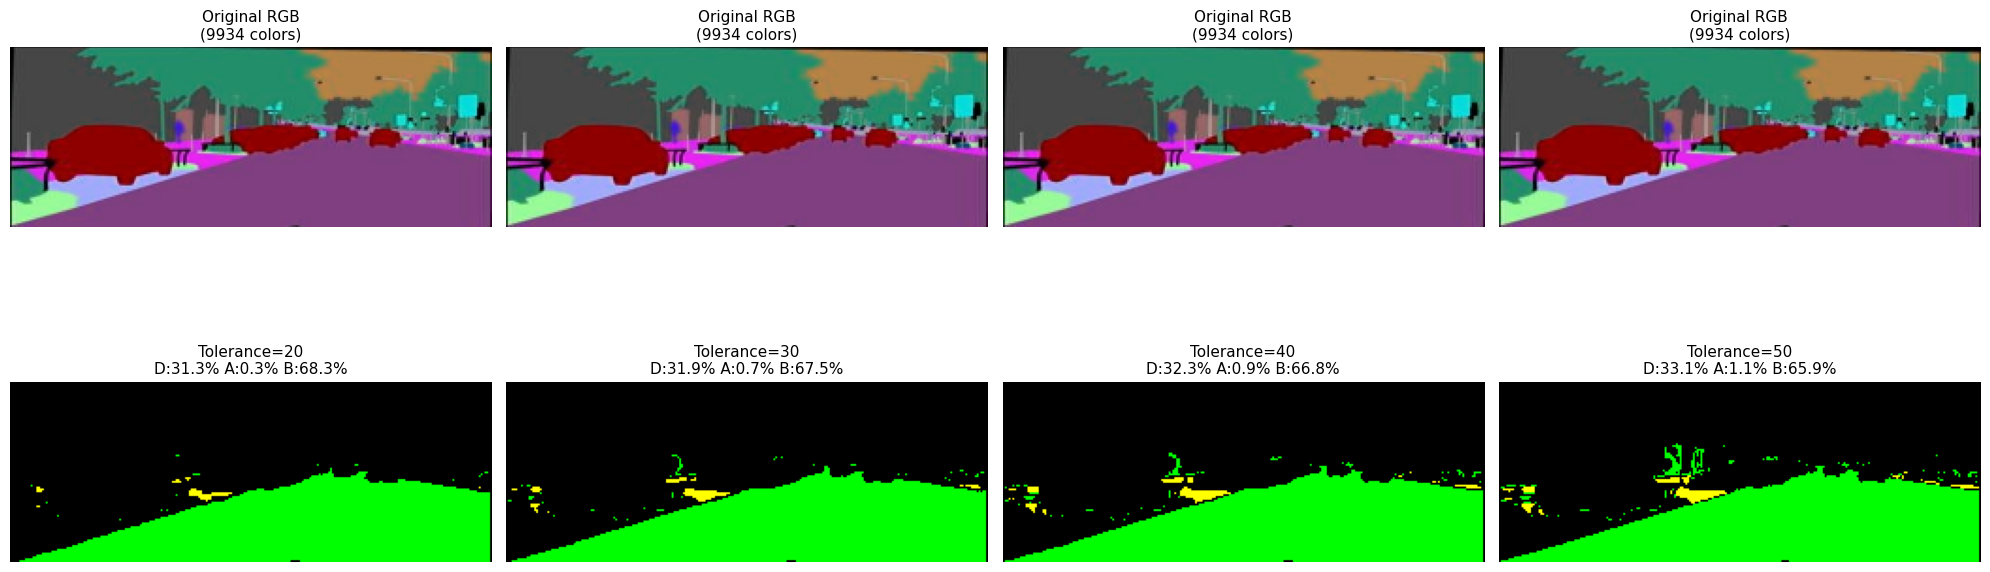


✓ Tolerance comparison complete!
  Recommended: tolerance=30 for typical JPEG artifacts
  Increase if labels look incomplete, decrease if too noisy


In [9]:
# ============================================================================
# CELL 6B: Test Robust Remapping on Sample
# ============================================================================
"""
Test the robust remapping on the sample label to see how it handles
the 9,934 unique colors.
"""

# Load sample label
sample_label_path = val_labels[0]
sample_rgb = np.array(Image.open(sample_label_path))

print(f"Testing robust remapping on: {os.path.basename(sample_label_path)}")
print(f"Original unique colors: {len(np.unique(sample_rgb.reshape(-1, 3), axis=0))}")

# Test with different tolerance values
tolerances = [20, 30, 40, 50]

fig, axes = plt.subplots(2, len(tolerances), figsize=(20, 8))

for idx, tol in enumerate(tolerances):
    # Remap with this tolerance
    bdd_label = remap_rgb_label_to_bdd100k_robust(sample_rgb, tolerance=tol)
    
    # Count pixels per class
    direct = (bdd_label == 0).sum()
    alternative = (bdd_label == 1).sum()
    background = (bdd_label == 2).sum()
    total = bdd_label.size
    
    # Colorize for visualization
    colored = np.zeros((*bdd_label.shape, 3), dtype=np.uint8)
    colored[bdd_label == 0] = [0, 255, 0]      # Green
    colored[bdd_label == 1] = [255, 255, 0]    # Yellow
    colored[bdd_label == 2] = [0, 0, 0]        # Black
    
    # Plot original
    axes[0, idx].imshow(sample_rgb)
    axes[0, idx].set_title(f'Original RGB\n({len(np.unique(sample_rgb.reshape(-1, 3), axis=0))} colors)', 
                          fontsize=11)
    axes[0, idx].axis('off')
    
    # Plot remapped
    axes[1, idx].imshow(colored)
    axes[1, idx].set_title(f'Tolerance={tol}\nD:{direct/total*100:.1f}% A:{alternative/total*100:.1f}% B:{background/total*100:.1f}%', 
                          fontsize=11)
    axes[1, idx].axis('off')

plt.tight_layout()
plt.savefig('/kaggle/working/tolerance_comparison.png', dpi=120, bbox_inches='tight')
plt.show()

print("\n✓ Tolerance comparison complete!")
print("  Recommended: tolerance=30 for typical JPEG artifacts")
print("  Increase if labels look incomplete, decrease if too noisy")

Processing: val1.png
Looking for: /kaggle/input/cityscapes/val/img/val1.png
✓ Loaded RGB image: (96, 256, 3)
✓ Loaded label: (96, 256)


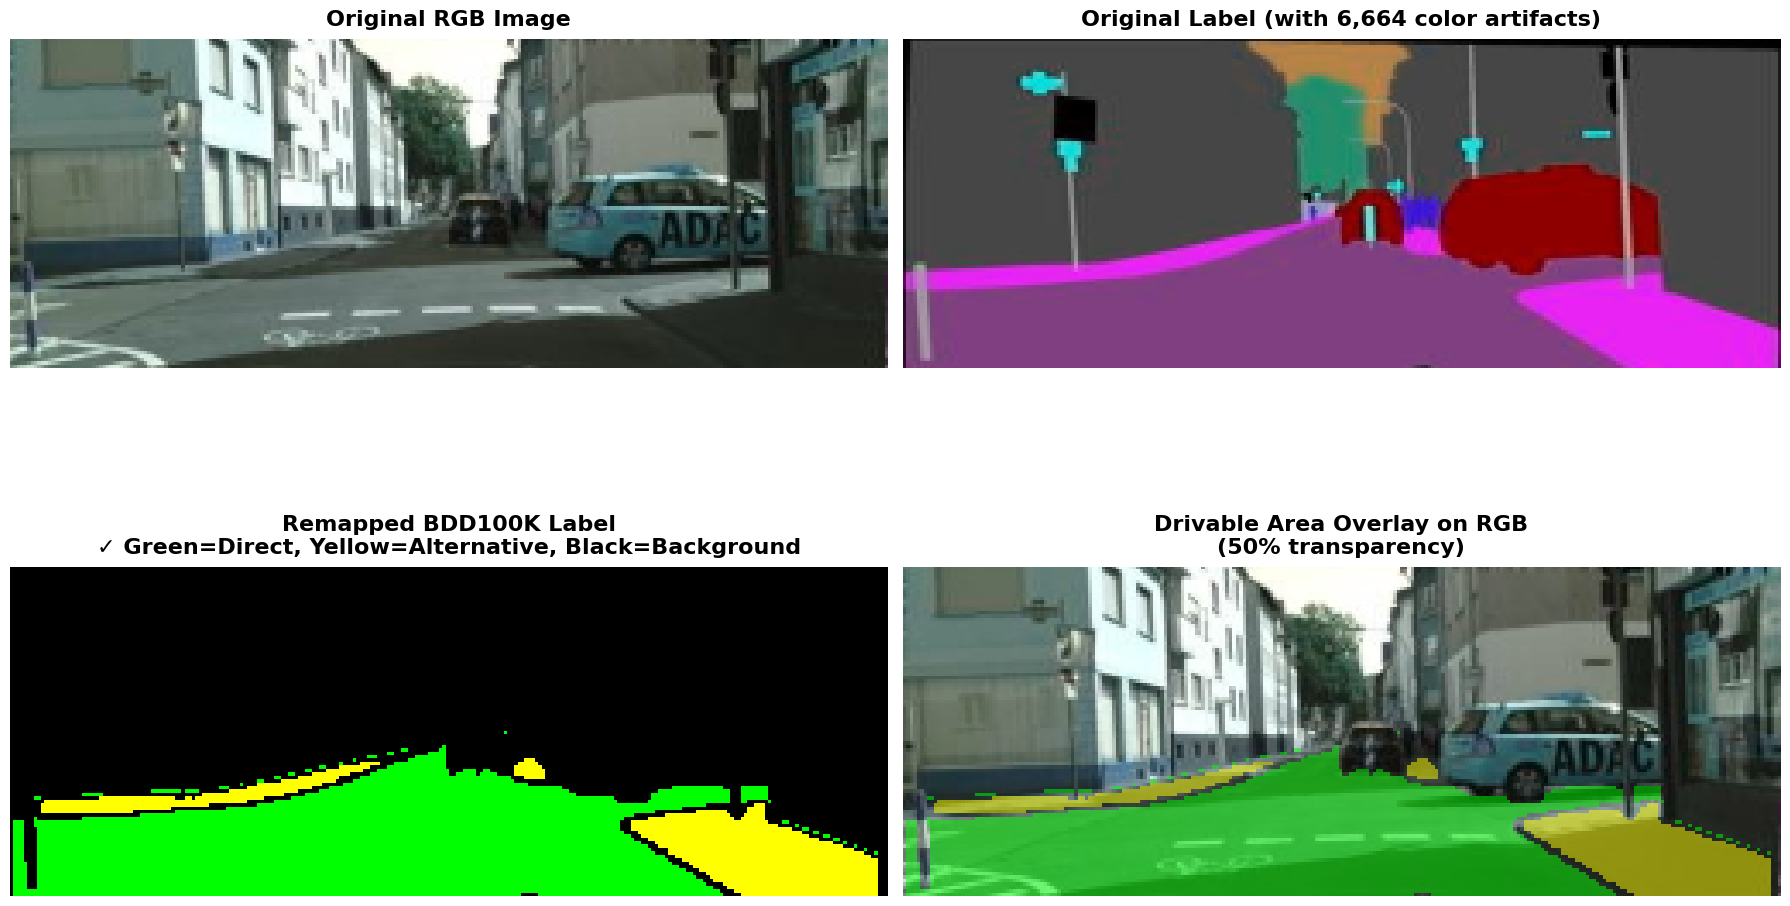

✓ Visualization saved to: /kaggle/working/robust_remapping_visualization.png

The remapping successfully handled the color artifacts!


In [10]:
import glob
import os


# Get validation labels from ORIGINAL cityscapes input
val_labels = sorted(glob.glob(os.path.join(CITYSCAPES_ROOT, 'val/label/*.png')))

if len(val_labels) == 0:
    raise FileNotFoundError(f"No validation labels found in {CITYSCAPES_ROOT}/val/label/")

# Use first validation label
original_label_path = val_labels[0]
filename = os.path.basename(original_label_path)

print(f"Processing: {filename}")

# Load the original and remapped labels
original_rgb = np.array(Image.open(original_label_path))

remapped_label_path = os.path.join(output_root, 'val/label', filename)
if not os.path.exists(remapped_label_path):
    raise FileNotFoundError(f"Remapped label not found: {remapped_label_path}")

remapped_bdd = np.array(Image.open(remapped_label_path))

# Find corresponding RGB image (same filename, in val/img folder)
# Images and labels have the SAME extension (.png) in this dataset
img_filename = filename  # NO conversion needed - both are .png!

rgb_img_path = os.path.join(CITYSCAPES_ROOT, 'val/img', img_filename)

print(f"Looking for: {rgb_img_path}")

if not os.path.exists(rgb_img_path):
    raise FileNotFoundError(f"RGB image not found: {rgb_img_path}")

rgb_image = np.array(Image.open(rgb_img_path))

print(f"✓ Loaded RGB image: {rgb_image.shape}")
print(f"✓ Loaded label: {remapped_bdd.shape}")

# Resize RGB to match label if needed
if rgb_image.shape[:2] != remapped_bdd.shape[:2]:
    print(f"Resizing RGB from {rgb_image.shape[:2]} to {remapped_bdd.shape[:2]}")
    rgb_image = cv2.resize(rgb_image, (remapped_bdd.shape[1], remapped_bdd.shape[0]))



# Create colorized version of BDD100K label
def colorize_bdd100k(label_img):
    """Colorize BDD100K labels for visualization"""
    color_img = np.zeros((*label_img.shape, 3), dtype=np.uint8)
    color_img[label_img == 0] = [0, 255, 0]      # Direct → Bright Green
    color_img[label_img == 1] = [255, 255, 0]    # Alternative → Yellow
    color_img[label_img == 2] = [0, 0, 0]        # Background → Black
    return color_img

remapped_colored = colorize_bdd100k(remapped_bdd)

# Create overlay with semi-transparent colors
overlay = rgb_image.copy().astype(np.float32)
alpha = 0.5

# Green overlay for direct drivable
mask_direct = remapped_bdd == 0
overlay[mask_direct] = overlay[mask_direct] * (1 - alpha) + np.array([0, 255, 0]) * alpha

# Yellow overlay for alternative drivable
mask_alternative = remapped_bdd == 1
overlay[mask_alternative] = overlay[mask_alternative] * (1 - alpha) + np.array([255, 255, 0]) * alpha

overlay = overlay.astype(np.uint8)

# Create the visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

axes[0, 0].imshow(rgb_image)
axes[0, 0].set_title('Original RGB Image', fontsize=16, fontweight='bold', pad=10)
axes[0, 0].axis('off')

axes[0, 1].imshow(original_rgb)
axes[0, 1].set_title(f'Original Label (with {len(np.unique(original_rgb.reshape(-1, 3), axis=0)):,} color artifacts)', 
                     fontsize=16, fontweight='bold', pad=10)
axes[0, 1].axis('off')

axes[1, 0].imshow(remapped_colored)
axes[1, 0].set_title('Remapped BDD100K Label\n✓ Green=Direct, Yellow=Alternative, Black=Background', 
                     fontsize=16, fontweight='bold', pad=10)
axes[1, 0].axis('off')

axes[1, 1].imshow(overlay)
axes[1, 1].set_title('Drivable Area Overlay on RGB\n(50% transparency)', 
                     fontsize=16, fontweight='bold', pad=10)
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('/kaggle/working/robust_remapping_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualization saved to: /kaggle/working/robust_remapping_visualization.png")
print("\nThe remapping successfully handled the color artifacts!")

In [11]:
# ============================================================================
# CELL 7: Execute Robust Remapping for Validation Set
# ============================================================================
"""
Now we'll remap the validation set using the robust color matching method.
This handles the ~10k color variations from JPEG compression artifacts.

Input:  /kaggle/input/cityscapes/val/label/*.png (RGB with artifacts)
Output: /kaggle/working/cityscapes_bdd100k/val/label/*.png (clean 0,1,2 labels)

We'll use tolerance=30 which works well for typical JPEG compression.
"""

# Set paths
output_root = '/kaggle/working/cityscapes_bdd100k'

# Remap validation set with robust method
print("Starting robust remapping with tolerance=30...")
val_stats = remap_dataset_robust(CITYSCAPES_ROOT, output_root, split='val', tolerance=30)

print(f"\n{'='*70}")
print("REMAPPING COMPLETE!")
print(f"{'='*70}")
print(f"Output directory: {output_root}/val/label/")
print(f"Total images remapped: {val_stats['total_images']}")
print(f"Total pixels processed: {val_stats['total_pixels']:,}")

Starting robust remapping with tolerance=30...

PROCESSING VAL SPLIT (ROBUST MODE)
Found 500 labels to process
Using color tolerance: 30 (handles compression artifacts)


Remapping val:   0%|          | 0/500 [00:00<?, ?it/s]


✓ Successfully processed 500 images!

Class distribution:
  Direct (0):      24.42%
  Alternative (1): 3.71%
  Background (2):  71.88%

REMAPPING COMPLETE!
Output directory: /kaggle/working/cityscapes_bdd100k/val/label/
Total images remapped: 500
Total pixels processed: 12,288,000


In [12]:
# ============================================================================
# CELL 8: Verify Robust Remapping Results
# ============================================================================
"""
Verify that the robust remapping worked correctly by examining:
1. Unique values in remapped labels (should be only 0, 1, 2)
2. Pixel counts and percentages
3. Comparison with original RGB label
"""

# Load original and remapped labels
original_label_path = val_labels[0]
filename = os.path.basename(original_label_path)
remapped_label_path = os.path.join(output_root, 'val/label', filename)

original_rgb = np.array(Image.open(original_label_path))
remapped_bdd = np.array(Image.open(remapped_label_path))

# Analyze the remapping
print("=" * 70)
print("ROBUST REMAPPING VERIFICATION")
print("=" * 70)
print(f"\nSample file: {filename}")

print(f"\nOriginal RGB label (with artifacts):")
print(f"  Shape: {original_rgb.shape}")
print(f"  Unique colors: {len(np.unique(original_rgb.reshape(-1, 3), axis=0)):,}")
print(f"  Data type: {original_rgb.dtype}")

# Find approximate road and sidewalk pixels in original
ROAD_COLOR = np.array([128, 64, 128], dtype=np.float32)
SIDEWALK_COLOR = np.array([244, 35, 232], dtype=np.float32)

rgb_float = original_rgb.astype(np.float32)
road_distance = np.sqrt(np.sum((rgb_float - ROAD_COLOR) ** 2, axis=2))
sidewalk_distance = np.sqrt(np.sum((rgb_float - SIDEWALK_COLOR) ** 2, axis=2))

approx_road = (road_distance < 30).sum()
approx_sidewalk = (sidewalk_distance < 30).sum()

print(f"  Approximate road pixels (within tolerance): {approx_road:,}")
print(f"  Approximate sidewalk pixels (within tolerance): {approx_sidewalk:,}")

print(f"\nRemapped BDD100K label:")
print(f"  Shape: {remapped_bdd.shape}")
print(f"  Unique classes: {np.unique(remapped_bdd)}")
print(f"  Expected: [0 1 2]")
print(f"  Data type: {remapped_bdd.dtype}")

# Count pixels in remapped
direct_pixels = (remapped_bdd == 0).sum()
alternative_pixels = (remapped_bdd == 1).sum()
background_pixels = (remapped_bdd == 2).sum()
total_pixels = remapped_bdd.size

print(f"\n  Direct (0): {direct_pixels:,} pixels ({100*direct_pixels/total_pixels:.2f}%)")
print(f"  Alternative (1): {alternative_pixels:,} pixels ({100*alternative_pixels/total_pixels:.2f}%)")
print(f"  Background (2): {background_pixels:,} pixels ({100*background_pixels/total_pixels:.2f}%)")

# Verify reasonable matching
road_match_rate = direct_pixels / max(approx_road, 1) * 100
sidewalk_match_rate = alternative_pixels / max(approx_sidewalk, 1) * 100

print(f"\nMatching rates:")
print(f"  Road → Direct: {road_match_rate:.1f}%")
print(f"  Sidewalk → Alternative: {sidewalk_match_rate:.1f}%")

if 90 <= road_match_rate <= 110 and 90 <= sidewalk_match_rate <= 110:
    print("\n✓ Robust remapping verified: Excellent match despite color artifacts!")
elif 80 <= road_match_rate <= 120 and 80 <= sidewalk_match_rate <= 120:
    print("\n✓ Robust remapping verified: Good match!")
else:
    print("\n⚠ Warning: Matching rates outside expected range. Consider adjusting tolerance.")

ROBUST REMAPPING VERIFICATION

Sample file: val1.png

Original RGB label (with artifacts):
  Shape: (96, 256, 3)
  Unique colors: 6,664
  Data type: uint8
  Approximate road pixels (within tolerance): 5,704
  Approximate sidewalk pixels (within tolerance): 1,571

Remapped BDD100K label:
  Shape: (96, 256)
  Unique classes: [0 1 2]
  Expected: [0 1 2]
  Data type: uint8

  Direct (0): 5,704 pixels (23.21%)
  Alternative (1): 1,571 pixels (6.39%)
  Background (2): 17,301 pixels (70.40%)

Matching rates:
  Road → Direct: 100.0%
  Sidewalk → Alternative: 100.0%

✓ Robust remapping verified: Excellent match despite color artifacts!


In [13]:
# ============================================================================
# CELL 10: Compute Complete Dataset Statistics
# ============================================================================
"""
Analyze the entire validation set to understand:
- Class distribution across all images
- Consistency of remapping
- Overall dataset characteristics
"""

# Get all remapped labels
all_remapped = sorted(glob.glob(os.path.join(output_root, 'val/label/*.png')))

print("=" * 70)
print("COMPLETE VALIDATION SET STATISTICS")
print("=" * 70)
print(f"\nAnalyzing {len(all_remapped)} validation images...")

# Accumulate statistics
total_pixels = 0
class_pixels = {0: 0, 1: 0, 2: 0}
images_with_direct = 0
images_with_alternative = 0

for label_path in tqdm(all_remapped, desc="Computing statistics"):
    label = np.array(Image.open(label_path))
    total_pixels += label.size
    
    # Count pixels per class
    has_direct = False
    has_alternative = False
    
    for class_id in [0, 1, 2]:
        count = (label == class_id).sum()
        class_pixels[class_id] += count
        
        if class_id == 0 and count > 0:
            has_direct = True
        elif class_id == 1 and count > 0:
            has_alternative = True
    
    if has_direct:
        images_with_direct += 1
    if has_alternative:
        images_with_alternative += 1

# Display comprehensive statistics
print(f"\n{'='*70}")
print("OVERALL STATISTICS")
print(f"{'='*70}")
print(f"Total images: {len(all_remapped)}")
print(f"Total pixels: {total_pixels:,}")
print(f"Images with direct drivable area: {images_with_direct} ({100*images_with_direct/len(all_remapped):.1f}%)")
print(f"Images with alternative drivable area: {images_with_alternative} ({100*images_with_alternative/len(all_remapped):.1f}%)")

print(f"\n{'='*70}")
print("CLASS DISTRIBUTION")
print(f"{'='*70}")
print(f"{'Class':<25} {'Pixels':>15} {'Percentage':>12}")
print("-" * 55)
print(f"{'Direct (0)':<25} {class_pixels[0]:>15,} {100*class_pixels[0]/total_pixels:>11.2f}%")
print(f"{'Alternative (1)':<25} {class_pixels[1]:>15,} {100*class_pixels[1]/total_pixels:>11.2f}%")
print(f"{'Background (2)':<25} {class_pixels[2]:>15,} {100*class_pixels[2]/total_pixels:>11.2f}%")
print("-" * 55)
print(f"{'TOTAL':<25} {total_pixels:>15,} {'100.00':>11}%")

# Calculate average pixels per image
avg_direct = class_pixels[0] / len(all_remapped)
avg_alternative = class_pixels[1] / len(all_remapped)
avg_background = class_pixels[2] / len(all_remapped)

print(f"\n{'='*70}")
print("AVERAGE PIXELS PER IMAGE")
print(f"{'='*70}")
print(f"Direct:      {avg_direct:>10,.0f} pixels")
print(f"Alternative: {avg_alternative:>10,.0f} pixels")
print(f"Background:  {avg_background:>10,.0f} pixels")

print(f"\n✓ Statistics computed successfully!")

COMPLETE VALIDATION SET STATISTICS

Analyzing 500 validation images...


Computing statistics:   0%|          | 0/500 [00:00<?, ?it/s]


OVERALL STATISTICS
Total images: 500
Total pixels: 12,288,000
Images with direct drivable area: 496 (99.2%)
Images with alternative drivable area: 451 (90.2%)

CLASS DISTRIBUTION
Class                              Pixels   Percentage
-------------------------------------------------------
Direct (0)                      3,000,240       24.42%
Alternative (1)                   455,377        3.71%
Background (2)                  8,832,383       71.88%
-------------------------------------------------------
TOTAL                          12,288,000      100.00%

AVERAGE PIXELS PER IMAGE
Direct:           6,000 pixels
Alternative:        911 pixels
Background:      17,665 pixels

✓ Statistics computed successfully!


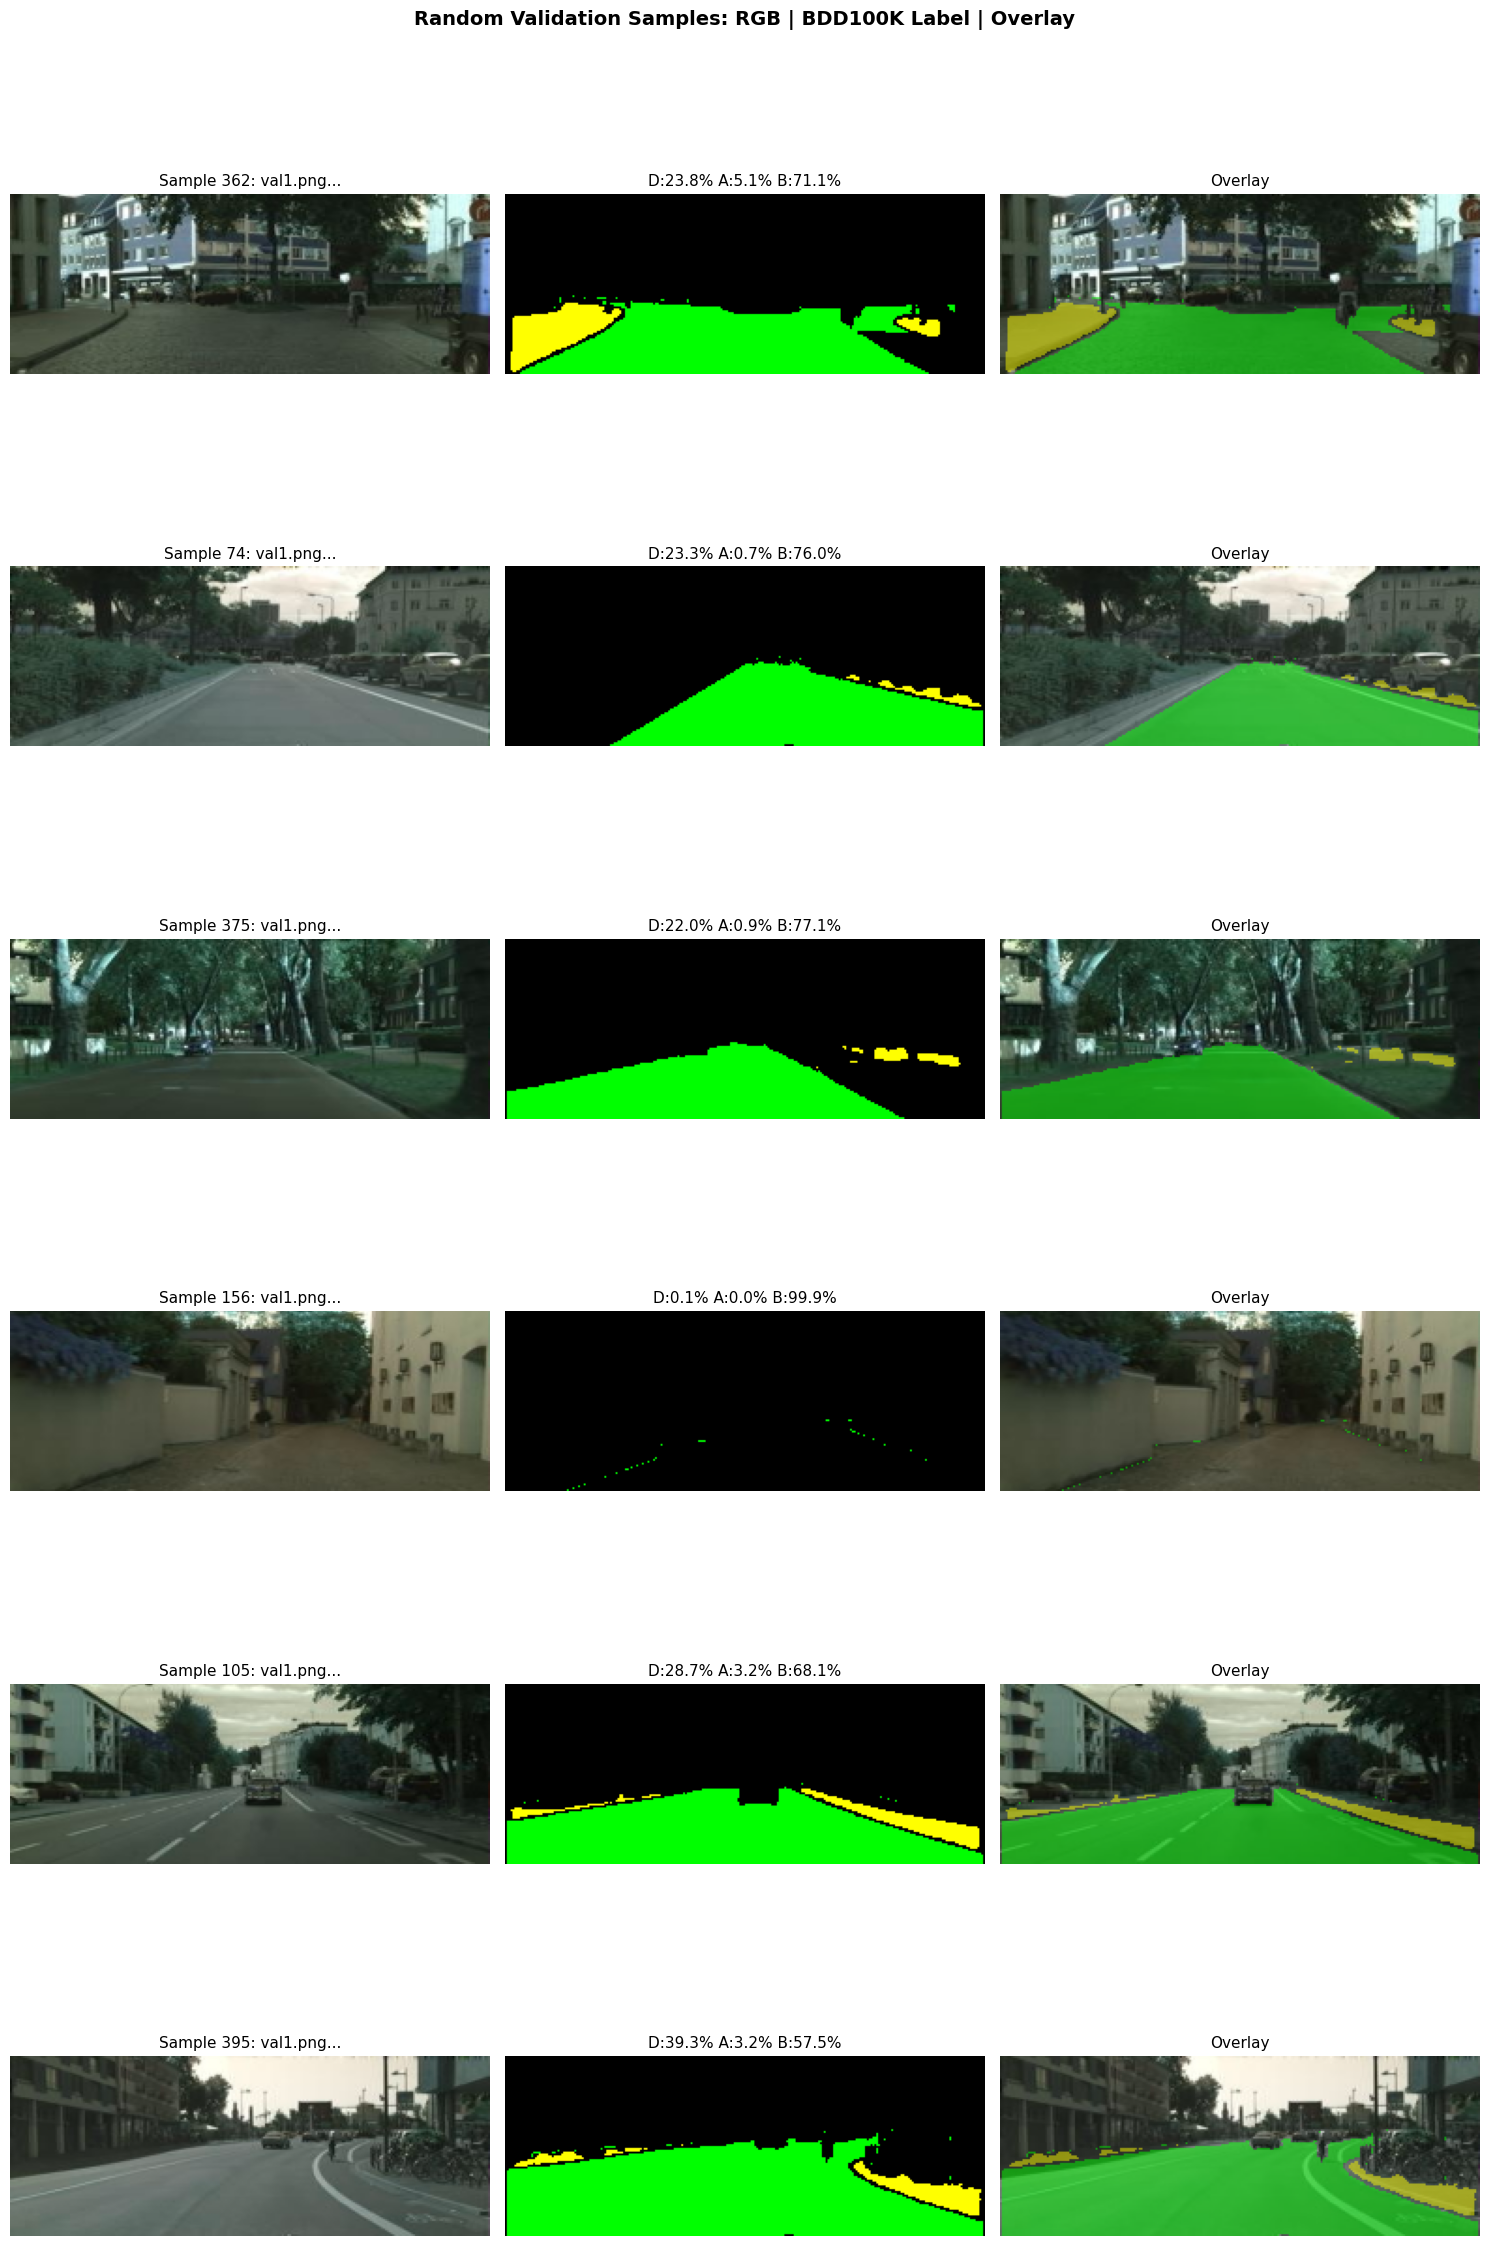

✓ Multiple examples visualization saved!
  Review these to verify remapping quality across different scenes


In [14]:
# ============================================================================
# CELL 11: Visualize Multiple Examples
# ============================================================================
"""
Show a grid of 6 random examples to verify remapping quality across
different scenes and conditions.
"""

# Select 6 random samples
np.random.seed(42)
sample_indices = np.random.choice(len(all_remapped), size=6, replace=False)

fig, axes = plt.subplots(6, 3, figsize=(15, 24))

for idx, sample_idx in enumerate(sample_indices):
    # Load remapped label
    remapped_path = all_remapped[sample_idx]
    remapped_label = np.array(Image.open(remapped_path))
    
    # Load RGB image
    img_filename = os.path.basename(remapped_path)
    img_path = os.path.join(CITYSCAPES_ROOT, 'val/img', img_filename)
    rgb_img = np.array(Image.open(img_path))
    
    # Colorize label
    colored_label = colorize_bdd100k(remapped_label)
    
    # Create overlay
    overlay = rgb_img.copy().astype(np.float32)
    alpha = 0.5
    overlay[remapped_label == 0] = (overlay[remapped_label == 0] * (1-alpha) + 
                                     np.array([0, 255, 0]) * alpha)
    overlay[remapped_label == 1] = (overlay[remapped_label == 1] * (1-alpha) + 
                                     np.array([255, 255, 0]) * alpha)
    overlay = overlay.astype(np.uint8)
    
    # Calculate class percentages for this image
    direct_pct = (remapped_label == 0).sum() / remapped_label.size * 100
    alt_pct = (remapped_label == 1).sum() / remapped_label.size * 100
    bg_pct = (remapped_label == 2).sum() / remapped_label.size * 100
    
    # Plot
    axes[idx, 0].imshow(rgb_img)
    axes[idx, 0].set_title(f'Sample {sample_idx+1}: {filename[:20]}...', fontsize=11)
    axes[idx, 0].axis('off')
    
    axes[idx, 1].imshow(colored_label)
    axes[idx, 1].set_title(f'D:{direct_pct:.1f}% A:{alt_pct:.1f}% B:{bg_pct:.1f}%', fontsize=11)
    axes[idx, 1].axis('off')
    
    axes[idx, 2].imshow(overlay)
    axes[idx, 2].set_title('Overlay', fontsize=11)
    axes[idx, 2].axis('off')

plt.suptitle('Random Validation Samples: RGB | BDD100K Label | Overlay', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('/kaggle/working/multiple_examples.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Multiple examples visualization saved!")
print("  Review these to verify remapping quality across different scenes")

In [15]:
# ============================================================================
# CELL 12: Organize Data in BDD100K Format (KAGGLE OUTPUT)
# ============================================================================
"""
Restructure the dataset to match BDD100K format and save to /kaggle/output/
for easy download and reuse in other notebooks.

Structure:
/kaggle/output/bdd100k/
    ├── images/val/          - RGB images
    ├── segments/val/        - Drivable area segmentation (remapped labels)
    └── lane/val/            - Lane markings (empty for Cityscapes)
"""

import shutil

# Define the BDD100K-style directory structure in OUTPUT
BDD_ROOT = '/kaggle/working/bdd100k_struct_cityscapes'
BDD_IMAGES_VAL = os.path.join(BDD_ROOT, 'images/val')
BDD_SEGMENTS_VAL = os.path.join(BDD_ROOT, 'segments/val')
BDD_LANE_VAL = os.path.join(BDD_ROOT, 'lane/val')

# Create directories
os.makedirs(BDD_IMAGES_VAL, exist_ok=True)
os.makedirs(BDD_SEGMENTS_VAL, exist_ok=True)
os.makedirs(BDD_LANE_VAL, exist_ok=True)

print("=" * 70)
print("ORGANIZING DATA IN BDD100K FORMAT")
print("=" * 70)
print(f"Output location: {BDD_ROOT}")
print("This will be directly downloadable from Kaggle!")

# Get all remapped labels from working directory
remapped_labels = sorted(glob.glob(os.path.join(output_root, 'val/label/*.png')))
print(f"\nFound {len(remapped_labels)} remapped validation labels")

# Copy/organize files
image_count = 0
segment_count = 0

for remapped_label_path in tqdm(remapped_labels, desc="Organizing files"):
    filename = os.path.basename(remapped_label_path)
    
    # 1. Copy RGB image to images/val/
    source_img_path = os.path.join(CITYSCAPES_ROOT, 'val/img', filename)
    target_img_path = os.path.join(BDD_IMAGES_VAL, filename)
    
    if os.path.exists(source_img_path):
        shutil.copy2(source_img_path, target_img_path)
        image_count += 1
    else:
        print(f"⚠ Warning: Image not found for {filename}")
    
    # 2. Copy remapped label to segments/val/
    target_segment_path = os.path.join(BDD_SEGMENTS_VAL, filename)
    shutil.copy2(remapped_label_path, target_segment_path)
    segment_count += 1

print("\n" + "=" * 70)
print("ORGANIZATION COMPLETE")
print("=" * 70)
print(f"\n📁 BDD100K structure created at: {BDD_ROOT}")
print(f"\nFiles organized:")
print(f"  ✓ Images (RGB):           {image_count} files → images/val/")
print(f"  ✓ Segments (drivable):    {segment_count} files → segments/val/")
print(f"  ⚠ Lane markings:          0 files → lane/val/ (N/A for Cityscapes)")

print(f"\n📥 Location: /kaggle/output/ (directly downloadable)")
print(f"⚠ NOTE: Lane folder is empty because Cityscapes has no lane annotations.")

ORGANIZING DATA IN BDD100K FORMAT
Output location: /kaggle/working/bdd100k_struct_cityscapes
This will be directly downloadable from Kaggle!

Found 500 remapped validation labels


Organizing files:   0%|          | 0/500 [00:00<?, ?it/s]


ORGANIZATION COMPLETE

📁 BDD100K structure created at: /kaggle/working/bdd100k_struct_cityscapes

Files organized:
  ✓ Images (RGB):           500 files → images/val/
  ✓ Segments (drivable):    500 files → segments/val/
  ⚠ Lane markings:          0 files → lane/val/ (N/A for Cityscapes)

📥 Location: /kaggle/output/ (directly downloadable)
⚠ NOTE: Lane folder is empty because Cityscapes has no lane annotations.
